In [1]:
import sys
print(sys.executable)

sys.path.append('../../')

/home/mshunya/project/100_GQCO/GQCO/.env/bin/python3.11


In [11]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Batch
from IPython.display import display, Math
from gqco.train import MyModel
from gqco.utils import fix_seed, arange_token, get_answer
from gqco.data import generate_data, RandomGraphDatasetWithClone
from gqco.solve import solve_from_token, plot_from_dict
from gqco.model import TransformerWithMoE

In [3]:
def data_from_adj(adj, args, num_clone, device):
    dataset = RandomGraphDatasetWithClone(adj, num_clone=num_clone, device=device)
    dataset.x = dataset.x.half()
    dataset.edge_attr = dataset.edge_attr.half()
    record = Batch.from_data_list(dataset)
    record['size'] = record['size'].tolist()[0]
    record['len'] = dataset.len()

    return adj, size, record

### Setup

In [6]:
task_path = '../../model/taskobjects.pkl'
checkpoint_path = '../../model/merged_model.ckpt'
testdata_path = '../../data/testdata.pkl'
seed=0

with open(task_path, 'rb') as f: 
    obj = pickle.load(f)
gqco = obj['task']
args = obj['args']

size_list = [3,4,5,6,7,8,9,10]

with open(testdata_path, 'rb') as f:
    testdata = pickle.load(f)

In [5]:
model = TransformerWithMoE(args)
model = MyModel.load_from_checkpoint(checkpoint_path, model=model, task=gqco, args=args)
model = model.to('cuda')
device = model.device

In [20]:
num_clone = 100
for size in [3, 4, 5]:#size_list:
    with open(f'./outputs/pkl/gqcoans_s42_t2.0_cl100_s{size}.pkl', 'rb') as f:
        dct = pickle.load(f)
    
    for i, (ans, token) in enumerate(zip(dct['answer'], dct['tokens'])):
        if ans == 1:
            continue
    
        savename = f'./outputs/svg/400/400_size{size}-id{i:03}'
        # print(f'Size: {size}, ID: {i:03}')
    
        ## For hard sample
        adj = testdata[size][i]
        adj, size, record = data_from_adj(adj.to(device), args, num_clone, device)


        max_itr = 100
        for sample_itr in range(max_itr):
            fix_seed(42+sample_itr)
            
            ## Generate circuits
            with torch.no_grad():
                with torch.autocast('cuda'):
                    out_tokens, probs_all, _, logits_all = model.forward(record, temperature=2.0)
            tokens_list = [arange_token(t, args) for t in out_tokens.detach().tolist()]
            energies = [gqco.compute_energy(t, adj, args.num_shot) for t in tokens_list]
    
    
            ## Get the best
            idx_min = energies.index(min(energies))
            token_min = tokens_list[idx_min]
            energy_min = energies[idx_min]
            
            ## Make result
            dict_pred, dict_true, qc = solve_from_token(gqco, token_min, adj, is_print=False, savefile=None)
            # plot_from_dict(dict_pred, dict_true, savefile=None)
    
            min_keys_pred, min_val_pred = get_answer(dict_pred, metric='max')
            min_keys_true, min_val_true = get_answer(dict_true, metric='min')
    
            is_correct = 0
            if len(set(min_keys_pred) & set(min_keys_true)):
                is_correct = 1
                break

        print(f'size: {size}, i: {i}, itr: {sample_itr}, correct: {is_correct}')

size: 3, i: 412, itr: 15, correct: 1
size: 4, i: 25, itr: 2, correct: 1
size: 5, i: 314, itr: 3, correct: 1
size: 5, i: 357, itr: 6, correct: 1


-- Token --
[301, 61, 61, 61, 931, 1313, 281, 552, 1597, 1524]


-- Circuit --


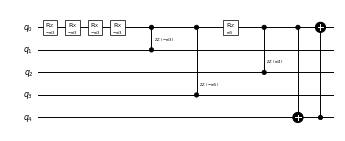



-- Transpiled circuit --


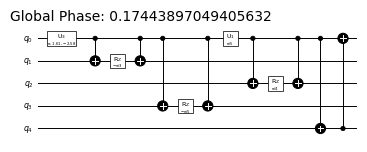

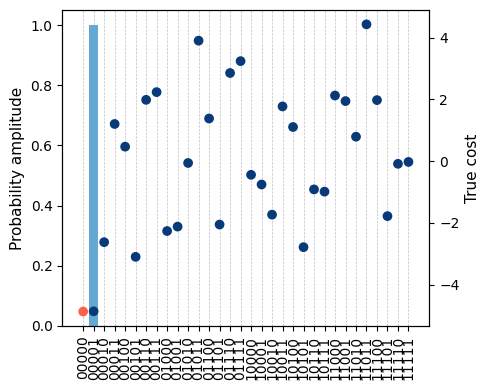

In [54]:
model.eval()

# seed = np.random.randint(1, 10000)
# seed += 1
seed = 42
size = 5

## Generate data
# adj, size, record = generate_data(args, num_clone=20, seed=seed, device=model.device, size=size)
adj, size, record = data_from_adj(adj.to(device), args, 100, device)

fix_seed(seed)

## Generate circuits
with torch.no_grad():
    with torch.autocast('cuda'):
        out_tokens, probs_all, _, logits_all = model.forward(record, temperature=2.0)
tokens_list = [arange_token(t, args) for t in out_tokens.detach().tolist()]
energies = [gqco.compute_energy(t, adj, args.num_shot) for t in tokens_list]

## Get the best
idx_min = energies.index(min(energies))
token_min = tokens_list[idx_min]
energy_min = energies[idx_min]

## Make result
dict_pred, dict_true, qc = solve_from_token(gqco, token_min, adj, is_print=True, savefile=None)
plot_from_dict(dict_pred, dict_true, savefile=None)

In [55]:
def plot_from_dict(dict_pred, dict_true, savefile, is_legend=False, figsize=(5, 4)):

    dict_pred = {key: dict_pred[key] for key in dict_true if key in dict_pred}

    # Extract keys and values
    keys = list(dict_pred.keys())
    values_pred = list(dict_pred.values())
    values_true = list(dict_true.values())

    # Create the figure and the first axis
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Create a bar plot for dict A
    ax1.grid(axis='x', which='both', color='gray', alpha=0.5, linestyle='--', linewidth=0.5, zorder=0)
    ax1.bar(keys, values_pred, color=sns.color_palette('Blues', 24)[12], label="Machine's answer", alpha=1, zorder=2)
    ax1.set_xlabel('Keys', size=11)
    ax1.set_ylabel("Probability amplitude", size=11)
    ax1.tick_params(axis="y")

    
    # Create the second axis
    ax2 = ax1.twinx()
    
    # Create a scatter plot for dict B
    min_value = min(values_true)
    min_indices = [i for i, value in enumerate(values_true) if value == min_value]
    
    # Scatter plot with different color for the minimum value
    colors = [sns.color_palette('Blues', 24)[-1]] * len(values_true)
    for i in min_indices:
        colors[i] = 'tomato'  # Change color of the minimum value
    
    ax2.scatter(keys, values_true, color=colors, label='Exact value', zorder=3)
    ax2.set_ylabel('True cost', size=11)
    ax2.tick_params(axis='y')

    ax1.set_xlabel(None)

    
    # Show the plot
    if is_legend:
        fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.96), ncol=2)
    ax1.tick_params(axis='x', rotation=90)
    plt.tight_layout()
    if savefile is not None:
        plt.savefig(f'{savefile}-probs.svg', bbox_inches='tight')
    plt.show()

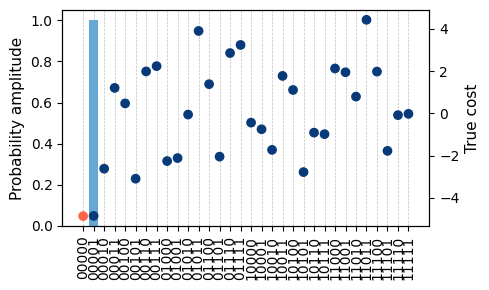

In [56]:
savename = f'./outputs/svg/400/400_size{size}-id{357:03}'
plot_from_dict(dict_pred, dict_true, savefile=savename, figsize=(max(5, 4), 3))

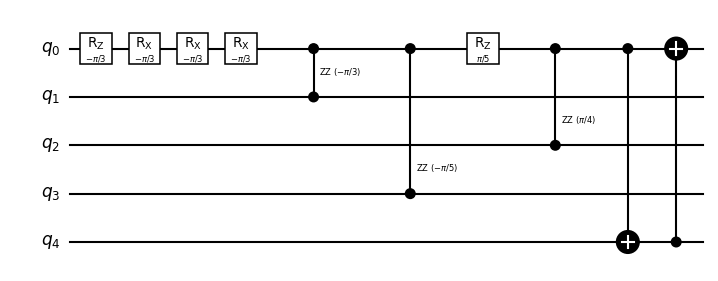

In [57]:
display(qc.qc.draw(output='mpl', style='bw', scale=0.751, filename=f'./{savename}-circ.svg'))